In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from nltools.datasets import download_collection
from nltools.data import Brain_Data
from nilearn.plotting import plot_glass_brain
import numpy as np
import pandas as pd
import glob

In [5]:
files=sorted(glob.glob("/Users/danicosme/Documents/code/sanlab/NSC_scripts/data/fx_cons/*CraveAll.nii.gz"))
metadata=pd.read_csv("/Users/danicosme/Documents/code/sanlab/NSC_scripts/fMRI/mvpa/metadata/metadata_rest_cons.csv")

print(files[1:5])
print('\n', metadata[1:5])

['/Users/danicosme/Documents/code/sanlab/NSC_scripts/data/fx_cons/CH001_reappraiseCraveAll.nii.gz', '/Users/danicosme/Documents/code/sanlab/NSC_scripts/data/fx_cons/CH002_lookCraveAll.nii.gz', '/Users/danicosme/Documents/code/sanlab/NSC_scripts/data/fx_cons/CH002_reappraiseCraveAll.nii.gz', '/Users/danicosme/Documents/code/sanlab/NSC_scripts/data/fx_cons/CH003_lookCraveAll.nii.gz']

    id study subjectID condition contrast  map
1   2    CH     CH001  regulate     rest  con
2   3    CH     CH002      look     rest  con
3   4    CH     CH002  regulate     rest  con
4   5    CH     CH003      look     rest  con


In [6]:
data = Brain_Data(files,X=metadata)

In [7]:
# partition data for development and holdout samples
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

train_inds, test_inds = next(GroupShuffleSplit(test_size=0.2, random_state=42).split(data.X, groups=data.X['subjectID']))
X_develop, X_holdout, Y_develop, Y_holdout = data.X.loc[train_inds], data.X.loc[test_inds], data.X['condition'][train_inds], data.X['condition'][test_inds]

#reset indices
X_dev = X_develop.reset_index(drop=True)

train_dev_inds, test_dev_inds = next(GroupShuffleSplit(test_size=0.2, random_state=65).split(X_dev, groups=X_dev['subjectID']))
X_dev_train, X_dev_test, Y_dev_train, Y_dev_test = X_dev.loc[train_dev_inds], X_dev.loc[test_dev_inds], X_dev['condition'][train_dev_inds], X_dev['condition'][test_dev_inds]

print('Development',X_develop[['subjectID','condition']][0:10])
print('Development train',X_dev_train[['subjectID','condition']][0:10])
print('Development test',X_dev_test[['subjectID','condition']][0:10])
print('\nHoldout', X_holdout[['subjectID','condition']][0:10])

print('\nDevelopment N = ', len(X_develop))
print('Development train N = ', len(X_dev_train))
print('Development test N = ', len(X_dev_test))
print('Holdout N =', len(X_holdout))



Development   subjectID condition
0     CH001      look
1     CH001  regulate
2     CH002      look
3     CH002  regulate
4     CH003      look
5     CH003  regulate
6     CH004      look
7     CH004  regulate
8     CH005      look
9     CH005  regulate
Development train    subjectID condition
0      CH001      look
1      CH001  regulate
2      CH002      look
3      CH002  regulate
6      CH004      look
7      CH004  regulate
8      CH005      look
9      CH005  regulate
10     CH006      look
11     CH006  regulate
Development test    subjectID condition
4      CH003      look
5      CH003  regulate
24     CH020      look
25     CH020  regulate
26     CH021      look
27     CH021  regulate
34     CH027      look
35     CH027  regulate
40     CH033      look
41     CH033  regulate

Holdout    subjectID condition
12     CH007      look
13     CH007  regulate
18     CH011      look
19     CH011  regulate
20     CH012      look
21     CH012  regulate
30     CH019      look
31     CH019

In [8]:
# subset train data
train = data[np.where(data.X['id'].isin(X_dev_train['id']))[0]]
print('Development train N = ', len(train))

look_train = data[np.where(train.X['condition']=='look')[0]]
print('Development train look N = ', len(look_train))

regulate_train = data[np.where(train.X['condition']=='regulate')[0]]
print('Development train regulate N = ', len(regulate_train))

dat_train = look_train.append(regulate_train)
dat_train.Y = pd.DataFrame(np.concatenate([np.ones(len(regulate_train)),np.zeros(len(look_train))]))
subject_id_train = np.concatenate([regulate_train.X['subjectID'].values,look_train.X['subjectID'].values])

# subset test data
test = data[np.where(data.X['id'].isin(X_dev_test['id']))[0]]
print('\nDevelopment test N = ', len(test))

look_test = data[np.where(test.X['condition']=='look')[0]]
print('Development test look N = ', len(look_test))

regulate_test = data[np.where(test.X['condition']=='regulate')[0]]
print('Development test regulate N = ', len(regulate_test))

dat_test = look_test.append(regulate_test)
dat_test.Y = pd.DataFrame(np.concatenate([np.ones(len(regulate_test)),np.zeros(len(look_test))]))
subject_id_test = np.concatenate([regulate_test.X['subjectID'].values,look_test.X['subjectID'].values])

Development train N =  332
Development train look N =  166
Development train regulate N =  166

Development test N =  84
Development test look N =  42
Development test regulate N =  42


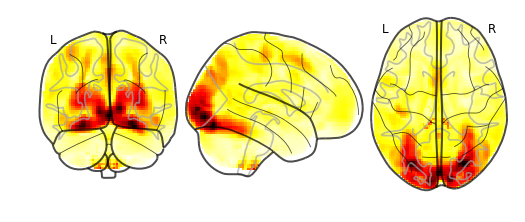

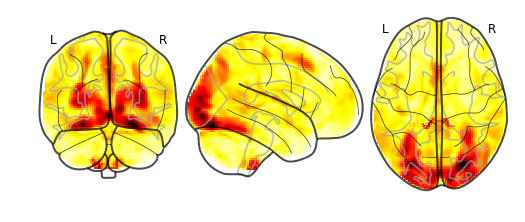

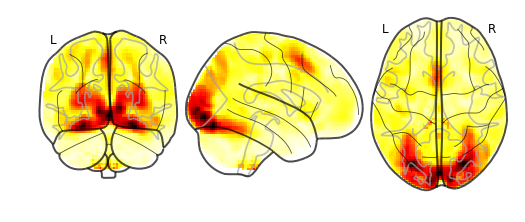

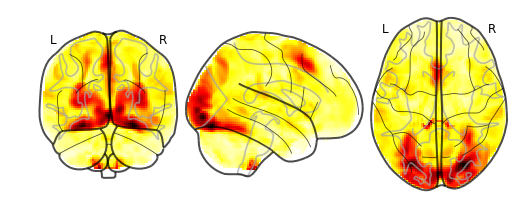

In [9]:
# plot mean activation
plot_glass_brain(look_train.mean().to_nifti())
plot_glass_brain(look_test.mean().to_nifti())


overall accuracy: 1.00
overall CV accuracy: 0.81
threshold is ignored for simple axial plots


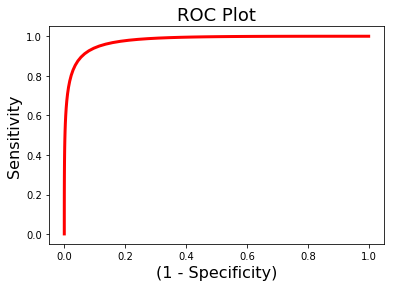

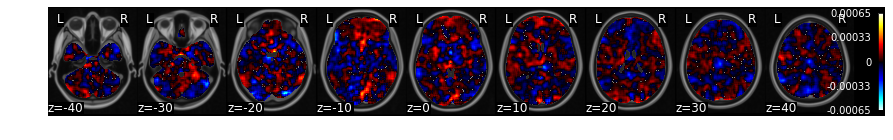

In [10]:
svm_stats = dat_train.predict(algorithm='svm', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id_train, 'stratified':data.Y}, **{'kernel':"linear"})


overall accuracy: 1.00
overall CV accuracy: 0.81
threshold is ignored for simple axial plots


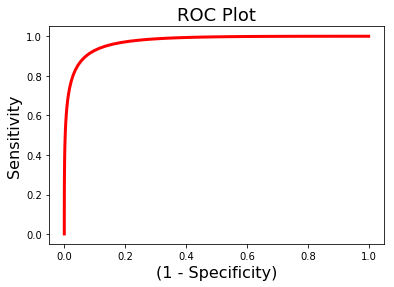

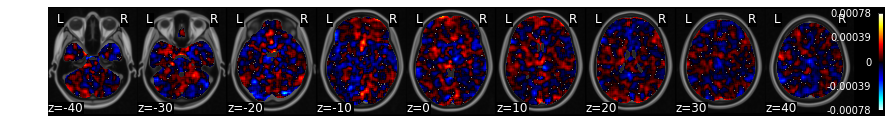

In [11]:
ridge_stats = dat_train.predict(algorithm='ridgeClassifier', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id':subject_id_train, 'stratified':data.Y})


overall accuracy: 1.00
overall CV accuracy: 0.81
threshold is ignored for simple axial plots


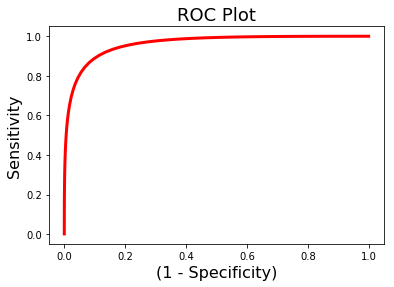

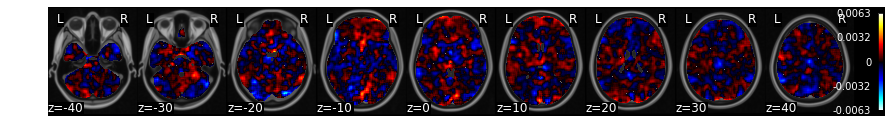

In [93]:
logistic_stats = dat_train.predict(algorithm='logistic', cv_dict={'type': 'kfolds','n_folds': 5, 'subject_id': subject_id_train, 'stratified':data.Y})


------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.83
Accuracy SE:        0.05
Accuracy p-value:   0.00
Sensitivity:        0.86
Specificity:        0.80
AUC:                0.90
PPV:                0.81
------------------------
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.82
Accuracy SE:        0.04
Accuracy p-value:   0.00
Sensitivity:        0.81
Specificity:        0.83
AUC:                0.90
PPV:                0.83
------------------------
------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.82
Accuracy SE:        0.04
Accuracy p-value:   0.00
Sensitivity:        0.81
Specificity:        0.83
AUC:                0.90
PPV:                0.83
------------------------


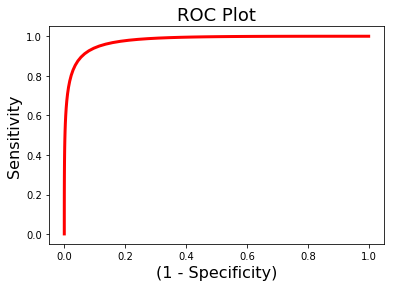

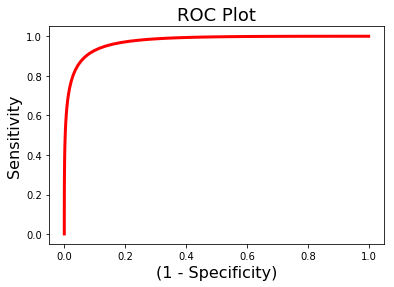

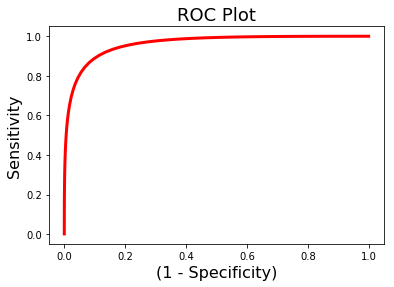

In [13]:
from nltools.analysis import Roc

# svm
roc_svm = Roc(input_values=svm_stats['dist_from_hyperplane_xval'], 
		binary_outcome=svm_stats['Y'].astype(bool))
roc_svm.plot()
roc_svm.summary()

# ridge
roc_ridge = Roc(input_values=ridge_stats['dist_from_hyperplane_xval'], 
		binary_outcome=ridge_stats['Y'].astype(bool))
roc_ridge.plot()
roc_ridge.summary()


# logistic
roc_logistic = Roc(input_values=logistic_stats['prob_xval'][:,1], 
		binary_outcome=logistic_stats['Y'].astype(bool))
roc_logistic.plot()
roc_logistic.summary()

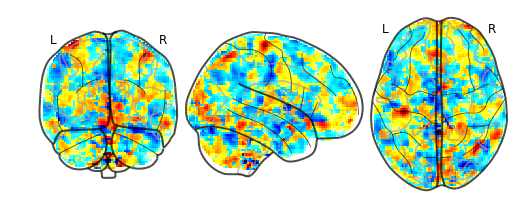

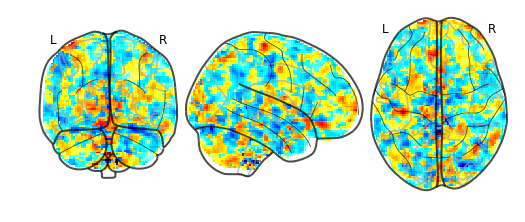

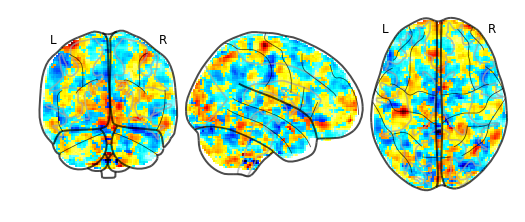

In [71]:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(svm_stats['weight_map'].to_nifti(), plot_abs=False)
plot_glass_brain(ridge_stats['weight_map'].to_nifti(), plot_abs=False)
plot_glass_brain(logistic_stats['weight_map'].to_nifti(), plot_abs=False)


[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -1.18319455e-05
 -2.58359230e-04 -5.25931260e-04]


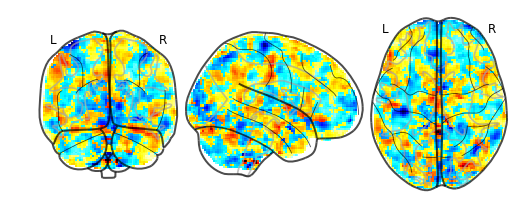

In [94]:
# flip sign so regulate is positive
logistic_stats['weight_map'].data = logistic_stats['weight_map'].data * -1
print(logistic_stats['weight_map'].data)
plot_glass_brain(logistic_stats['weight_map'].to_nifti(), plot_abs=False)


In [95]:
# save weight map as nifti
logistic_stats['weight_map'].write('/Users/danicosme/Documents/code/sanlab/neural-signatures-health-neuro/neural_signatures/multivariate.nii')


In [97]:
# save training partition info
X_dev_train.to_csv("/Users/danicosme/Documents/code/sanlab/neural-signatures-health-neuro/neural_signatures/train.csv")
